# Node Attribute Inference (multi-class) using GraphSAGE and the Pubmed-Diabetes citation network with calibration

This notebook demonstrates probability calibration for multi-class node attribute inference. The classifier used is GraphSAGE and the dataset is the citation network Pubmed-Diabetes.

The notebook demonstrates the use of `stellargraph`'s `TemperatureCalibration` and `IsotonicCalibration` classes as well as supporting methods for calculating the Expected Calibration Error (ECE) and plotting reliability diagrams.

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from keras import layers, optimizers, losses, metrics, Model
import tensorflow as tf

import numpy as np

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.isotonic import IsotonicRegression

from sklearn.metrics import accuracy_score

from stellargraph import TemperatureCalibration, IsotonicCalibration
from stellargraph import plot_reliability_diagram, expected_calibration_error

Using TensorFlow backend.


In [2]:
# Given a GraphSAGE model, a node mapper, and the number of predictions per point
# this method makes n_predictions number of predictions and then returns the average
# prediction for each query point.
def predict(model, mapper, n_predictions=1):
    preds = []
    for i in range(n_predictions):
        preds.append(model.predict_generator(mapper))
    preds_ar = np.array(preds)
    print(preds_ar.shape)
    return np.mean(preds_ar, axis=0)

### Some global parameters

In [3]:
epochs = 20
n_predictions = 5  # number of predictions per query point

### Loading the Pubmed-Diabetes network data

**Downloading the dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/Pubmed-Diabetes.tgz

The following is the description of the dataset:

> The Pubmed Diabetes dataset consists of 19717 scientific publications from PubMed database 
> pertaining to diabetes classified into one of three classes. The citation network consists 
> of 44338 links. Each publication in the dataset is described by a TF/IDF weighted word 
> vector from a dictionary which consists of 500 unique words.

Download and unzip the `Pubmed-Diabetes.tgz` file to a location on your computer.

Before proceeding use the script at https://github.com/stellargraph/data-science/tree/devel/PubMed to process the raw data into a format that can be read by `networkx`.

Set the `data_dir` variable to point to the location of the processed dataset.

In [4]:
data_dir = "~/data/pubmed/Pubmed-Diabetes/data"

Load the graph from edgelist

In [5]:
edgelist = pd.read_table(os.path.join(data_dir, 'Pubmed-Diabetes.DIRECTED.cites.tab'), 
                         skiprows=2, 
                         header=None )
edgelist.drop(columns=[0,2], inplace=True)
edgelist.columns = ['source', 'target']
# delete unneccessary prefix 
edgelist['source'] = edgelist['source'].map(lambda x: x.lstrip('paper:')) 
edgelist['target'] = edgelist['target'].map(lambda x: x.lstrip('paper:'))
edgelist["label"] = "cites"  # set the edge type

In [6]:
edgelist.head()

,source,target,label
0,19127292,17363749,cites
1,19668377,17293876,cites
2,1313726,3002783,cites
3,19110882,14578298,cites
4,18606979,10333910,cites


In [7]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

Load the features and subject for the nodes

In [8]:
node_data = pd.read_csv(os.path.join(data_dir, "Pubmed-Diabetes.csv") )
node_data['label'] = node_data['label'].astype(str)

In [9]:
node_data.head()

,label,pid,w-0,w-0001,w-001,w-01,w-02,w-05,w-1,w-10,...,w-vitro,w-vivo,w-vs,w-week,w-weight,w-wherea,w-women,w-x,w-year,w-young
0,1,12187484,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0
1,1,2344352,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.041603,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0
2,1,14654069,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.021497,0.045617,0.00000,0.0,0.0,0.0,0.0
3,2,16443886,0.008322,0.0,0.0,0.0,0.0,0.0,0.019854,0.016963,...,0.0,0.000000,0.0,0.000000,0.000000,0.02367,0.0,0.0,0.0,0.0
4,1,2684155,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0


In [10]:
set(node_data["label"])

{'1', '2', '3'}

In [11]:
node_data['pid'].dtype

dtype('int64')

In [12]:
node_data['pid'] = node_data.pid.astype(str)

In [13]:
node_data.index = node_data['pid']
node_data.drop(columns=['pid'], inplace=True)
node_data.head()

,label,w-0,w-0001,w-001,w-01,w-02,w-05,w-1,w-10,w-100,...,w-vitro,w-vivo,w-vs,w-week,w-weight,w-wherea,w-women,w-x,w-year,w-young
pid,,,,,,,,,,,,,,,,,,,,,
12187484,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0
2344352,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.041603,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0
14654069,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.021497,0.045617,0.00000,0.0,0.0,0.0,0.0
16443886,2,0.008322,0.0,0.0,0.0,0.0,0.0,0.019854,0.016963,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.02367,0.0,0.0,0.0,0.0
2684155,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [14]:
train_data, test_data = model_selection.train_test_split(node_data, 
                                                         train_size=0.75, 
                                                         test_size=None, 
                                                         stratify=node_data['label'])
train_data, val_data = model_selection.train_test_split(train_data, 
                                                        train_size=0.75, 
                                                        test_size=None, 
                                                        stratify=train_data['label'])



In [15]:
train_data.shape, val_data.shape, test_data.shape

((11090, 501), (3697, 501), (4930, 501))

In [16]:
train_data.head()

,label,w-0,w-0001,w-001,w-01,w-02,w-05,w-1,w-10,w-100,...,w-vitro,w-vivo,w-vs,w-week,w-weight,w-wherea,w-women,w-x,w-year,w-young
pid,,,,,,,,,,,,,,,,,,,,,
17466512,3,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10959068,2,0.007750,0.029956,0.0,0.0,0.000000,0.0,0.012328,0.015799,0.0,...,0.0,0.0,0.020814,0.0,0.0,0.0,0.0,0.0,0.000000,0.030006
8908656,3,0.015654,0.000000,0.0,0.0,0.027915,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.043269,0.000000
10971152,3,0.027497,0.079708,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.012667,0.000000
12357296,2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.026196,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.040465,0.000000


In [17]:
val_data.head()

,label,w-0,w-0001,w-001,w-01,w-02,w-05,w-1,w-10,w-100,...,w-vitro,w-vivo,w-vs,w-week,w-weight,w-wherea,w-women,w-x,w-year,w-young
pid,,,,,,,,,,,,,,,,,,,,,
3100306,1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.027314,0.0,0.0,0.000000,0.0,0.0
8757600,1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.057552,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.112565,0.0,0.0
12065235,1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.006688,0.000000,0.0,...,0.031075,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
14530204,3,0.029832,0.0,0.038515,0.020055,0.0,0.0,0.000000,0.015202,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
15195686,1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [18]:
test_data.head()

,label,w-0,w-0001,w-001,w-01,w-02,w-05,w-1,w-10,w-100,...,w-vitro,w-vivo,w-vs,w-week,w-weight,w-wherea,w-women,w-x,w-year,w-young
pid,,,,,,,,,,,,,,,,,,,,,
8816980,2,0.015971,0.0,0.0,0.0,0.0,0.019922,0.012701,0.000000,0.0,...,0.00000,0.029416,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
17054272,3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.0,0.029163,0.0,0.0,0.019174,0.0,0.000000,0.0
6571875,1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.041319,0.0,...,0.03745,0.037336,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
17876371,1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
16567818,2,0.013176,0.0,0.0,0.0,0.0,0.000000,0.036674,0.000000,0.0,...,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.137094,0.0,0.024279,0.0


Note using stratified sampling gives the following counts:

In [19]:
from collections import Counter
Counter(train_data['label']), Counter(val_data['label']), Counter(test_data['label'])

(Counter({'3': 4353, '2': 4429, '1': 2308}),
 Counter({'1': 769, '3': 1451, '2': 1477}),
 Counter({'2': 1969, '3': 1935, '1': 1026}))

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [20]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["label"]].to_dict('records'))
val_targets = target_encoding.fit_transform(val_data[["label"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["label"]].to_dict('records'))

In [21]:
train_targets

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The dataset contains attributes 'w-*' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [22]:
node_features = node_data.drop(columns=['label'])

In [23]:
node_features.head()

,w-0,w-0001,w-001,w-01,w-02,w-05,w-1,w-10,w-100,w-11,...,w-vitro,w-vivo,w-vs,w-week,w-weight,w-wherea,w-women,w-x,w-year,w-young
pid,,,,,,,,,,,,,,,,,,,,,
12187484,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0
2344352,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.041603,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0
14654069,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.021497,0.045617,0.00000,0.0,0.0,0.0,0.0
16443886,0.008322,0.0,0.0,0.0,0.0,0.0,0.019854,0.016963,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.02367,0.0,0.0,0.0,0.0
2684155,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0


## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [24]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [25]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44327

 Node types:
  default: [19717]
    Edge types: default-cites->default

 Edge types:
    default-cites->default: [44327]



To feed data from the graph to the Keras model we need a mapper. The mappers are specialized to the model and the learning task so we choose the `GraphSAGENodeMapper` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [26]:
batch_size = 50; num_samples = [10, 5]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [27]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

For training we map only the training nodes returned from our splitter and the target values.

In [28]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [29]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=train_gen,
    bias=True,
    dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers. Note that we need to use the `G.get_target_size` method to find the number of categories in the data.

In [30]:
x_inp, x_out = graphsage_model.default_model(flatten_output=True)
logits = layers.Dense(units=train_targets.shape[1], activation="linear")(x_out)

prediction = layers.Activation(activation="softmax")(logits)

In [31]:
prediction.shape

TensorShape([Dimension(None), Dimension(3)])

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [32]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [33]:
val_gen = generator.flow(val_data.index, val_targets)
test_gen = generator.flow(test_data.index, test_targets)

In [34]:
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    verbose=0,
    shuffle=True,
)

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

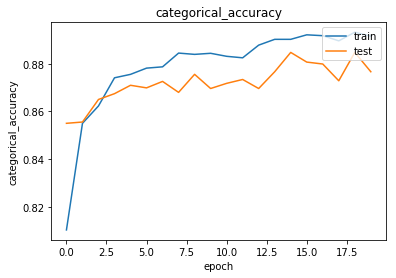

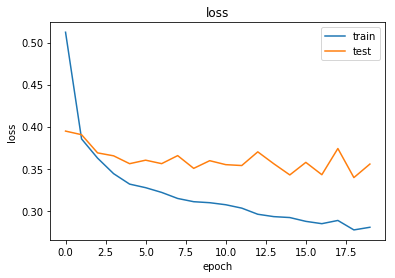

In [36]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [37]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.3255
	categorical_accuracy: 0.8757


## Calibration Curves

We estimate and plot the calibration curve for each class.

Start by making predictions for the test set

In [38]:
test_nodes = test_data.index
test_mapper = generator.flow(test_nodes)

In [39]:
# test_predictions holds the softmax outputs
test_predictions = predict(model, test_mapper, n_predictions=n_predictions)

(5, 4930, 3)


In [40]:
# This produces a list of dictionaries (one entry per point in test set) and one entry
# in the dictionary for each class label, label=1, label=2, label=3.
y_test_pred = target_encoding.inverse_transform(test_predictions)

In [41]:
# Convert the list of dictionaries to a dataframe so that it is easier to work with the data
test_pred_results = pd.DataFrame(y_test_pred)
test_pred_results.index = test_data.index
test_pred_results.head()

,label=1,label=2,label=3
pid,,,
8816980,0.004174,0.992969,0.002856
17054272,0.000804,0.013824,0.985372
6571875,0.954250,0.032951,0.012799
17876371,0.785978,0.036042,0.177980
16567818,0.004519,0.760670,0.234811


We are going to draw one calibration curve for each column in `test_pred_results`.

In [42]:
test_pred = test_pred_results.values
test_pred.shape

(4930, 3)

In [43]:
calibration_data = []
for i in range(test_pred.shape[1]):  # iterate over classes
    calibration_data.append(calibration_curve(y_prob=test_pred[:, i], 
                                               y_true=test_targets[:, i], 
                                               n_bins=10, 
                                               normalize=True))

In [44]:
calibration_data[0], type(calibration_data[0])

((array([0.01346894, 0.28930818, 0.38157895, 0.46774194, 0.32352941,
         0.66666667, 0.64      , 0.71014493, 0.8125    , 0.97014925]),
  array([0.00726883, 0.14379937, 0.24876289, 0.35514922, 0.44978891,
         0.55065802, 0.65018628, 0.75861204, 0.85724959, 0.96809438])),
 tuple)

Also calculate ECE for each class

In [45]:
ece = []
for i in range(test_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_data[i]
    ece.append(expected_calibration_error(prediction_probabilities=test_pred[:, i], 
                                          accuracy=fraction_of_positives, 
                                          confidence=mean_predicted_value))

In [46]:
ece

[0.01711741577578336, 0.027878891193868077, 0.029364284099032016]

Draw the reliability diagrams for each class

In [47]:
for i, data in enumerate(calibration_data):
    print(type(data))
    a, b = data
    print(a, b)
    break

<class 'tuple'>
[0.01346894 0.28930818 0.38157895 0.46774194 0.32352941 0.66666667
 0.64       0.71014493 0.8125     0.97014925] [0.00726883 0.14379937 0.24876289 0.35514922 0.44978891 0.55065802
 0.65018628 0.75861204 0.85724959 0.96809438]


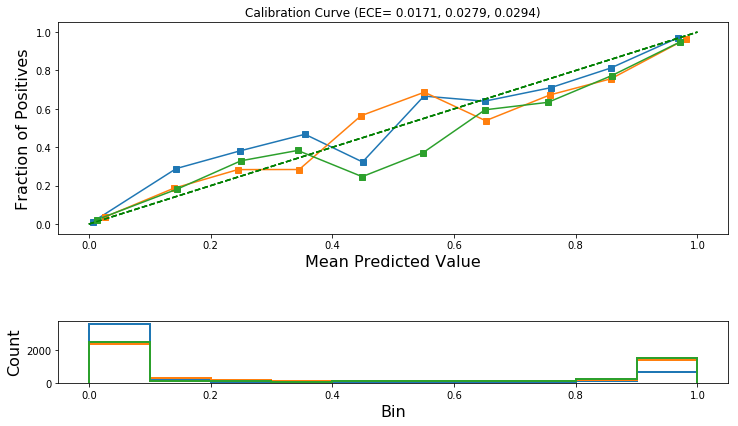

In [48]:
plot_reliability_diagram(calibration_data, test_pred, ece=ece)

## Temperature scaling calibration

In [49]:
# this model gives the output before the final layer softmax activation.
score_model = Model(inputs=x_inp, outputs=logits)

Prepare the training data such that inputs are the model output logits and corresponding true class labels are the one-hot encoded.

Training data is from the  validation set

In [50]:
val_nodes = val_data.index
val_mapper = generator.flow(val_nodes)

In [51]:
test_score_predictions = predict(score_model, test_mapper, n_predictions=n_predictions)
val_score_predictions = predict(score_model, val_mapper, n_predictions=n_predictions)

(5, 4930, 3)
(5, 3697, 3)


In [52]:
test_score_predictions.shape, val_score_predictions.shape

((4930, 3), (3697, 3))

In [53]:
x_cal_train_all = val_score_predictions
y_cal_train_all = val_targets

We are going to split the above data to a training and validation set. We are going to use the latter for early stopping.

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
x_cal_train, x_cal_val, y_cal_train, y_cal_val = train_test_split(x_cal_train_all, y_cal_train_all)

In [56]:
x_cal_train.shape, x_cal_val.shape, y_cal_train.shape, y_cal_val.shape

((2772, 3), (925, 3), (2772, 3), (925, 3))

In [57]:
calibration_model_temperature = TemperatureCalibration(epochs=1000)
calibration_model_temperature

In [58]:
calibration_model_temperature.fit(x_train=x_cal_train, 
                                  y_train=y_cal_train, 
                                  x_val=x_cal_val, 
                                  y_val=y_cal_val)

Using Early Stopping based on performance evaluated on given validation set.


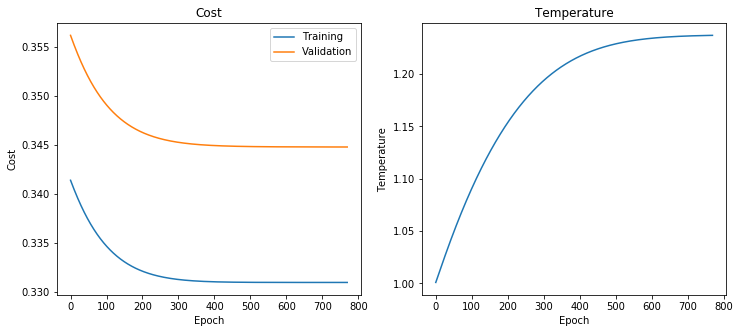

In [59]:
calibration_model_temperature.plot_training_history()

Now we can take the GraphSAGE logits, scale them by `temperature` and then apply the `softmax` to obtain the calibrated probabilities for each class.

**Note** that scaling the logits by `temperature` does not change the predictions so the model's accuracy will not change and there is no need to recalculate them.

In [60]:
test_predictions_calibrated_temperature = calibration_model_temperature.predict(x=test_score_predictions)
test_predictions_calibrated_temperature.shape

(4930, 3)

Now plot the calibration curves and calculate the ECE for each class

In [61]:
calibration_data_after_temperature_scaling = []
for i in range(test_predictions_calibrated_temperature.shape[1]):  # iterate over classes
    calibration_data_after_temperature_scaling.append(calibration_curve(y_prob=test_predictions_calibrated_temperature[:, i], 
                                                             y_true=test_targets[:, i], 
                                                             n_bins=10, 
                                                             normalize=True))

In [62]:
ece_after_scaling_temperature = []
for i in range(test_predictions_calibrated_temperature.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_data_after_temperature_scaling[i]
    ece_after_scaling_temperature.append(expected_calibration_error(prediction_probabilities=test_predictions_calibrated_temperature[:, i], 
                                                        accuracy=fraction_of_positives, 
                                                        confidence=mean_predicted_value))

In [63]:
ece_after_scaling_temperature

[0.01394502629084609, 0.014080679289691714, 0.01661438066922788]

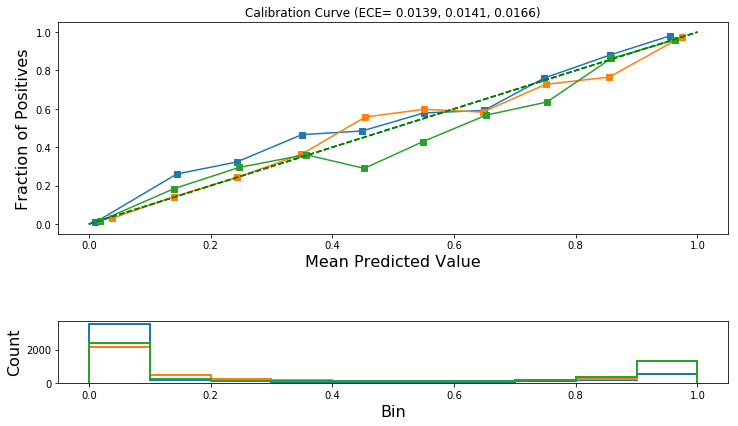

In [64]:
plot_reliability_diagram(calibration_data_after_temperature_scaling, 
                    test_predictions_calibrated_temperature, 
                    ece=ece_after_scaling_temperature )

## Isotonic Regression

We extend Isotonic calibration to the multi-class case by calibrating OVR models, one for each class. At test time, we calibrate the predictions for each class and then normalize the vector to unit norm so that the output of the calibration is a probability distribution.

**Note** that Isotonic Calibration needs the classifier's probabilistic model outputs as input. 

In [65]:
test_pred.shape # Holds the probabilistic predictions for each query point

(4930, 3)

In [66]:
# The probabilistic prediction for the validation set
val_predictions = predict(model, val_mapper, n_predictions=n_predictions)
val_predictions.shape

(5, 3697, 3)


(3697, 3)

In [67]:
isotonic_calib = IsotonicCalibration()

In [68]:
isotonic_calib.fit(x_train=val_predictions, y_train=val_targets)

In [69]:
test_pred_calibrated_isotonic = isotonic_calib.predict(test_pred)
test_pred_calibrated_isotonic.shape

(4930, 3)

Calculate ECE after calibration and plot the reliability diagram

In [70]:
calibration_data_after_isotonic_scaling = []
for i in range(test_pred_calibrated_isotonic.shape[1]):  # iterate over classes
    calibration_data_after_isotonic_scaling.append(calibration_curve(y_prob=test_pred_calibrated_isotonic[:, i], 
                                                                      y_true=test_targets[:, i], 
                                                                      n_bins=10, 
                                                                      normalize=True))

In [71]:
ece_after_scaling_isotonic = []
for i in range(test_pred_calibrated_isotonic.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_data_after_isotonic_scaling[i]
    ece_after_scaling_isotonic.append(expected_calibration_error(prediction_probabilities=test_pred_calibrated_isotonic[:, i], 
                                                                 accuracy=fraction_of_positives, 
                                                                 confidence=mean_predicted_value))

In [72]:
ece_after_scaling_isotonic

[0.010222018597607345, 0.012212982583408664, 0.013291318327224006]

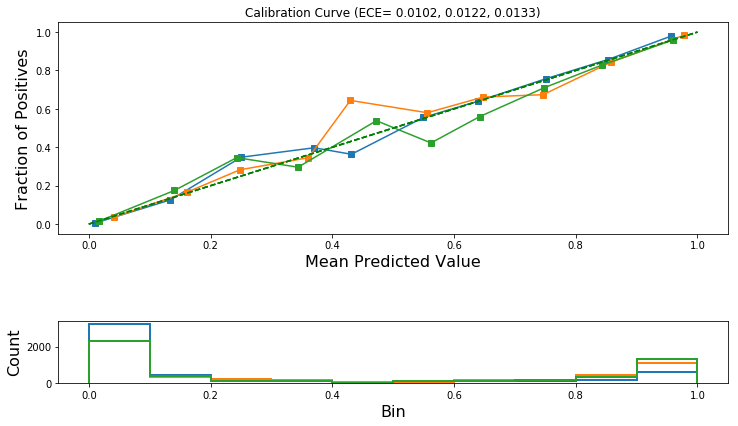

In [73]:
plot_reliability_diagram(calibration_data_after_isotonic_scaling,
                    test_pred_calibrated_isotonic, 
                    ece=ece_after_scaling_isotonic)

### Let's print the ECE before calibration and after Temperature Scaling and Isotonic Regression to summarize our results.

In [74]:
cal_error = ",".join(format(e, " 0.4f") for e in ece)
print("ECE before calibration:         {}".format(cal_error))
cal_error = ",".join(format(e, " 0.4f") for e in ece_after_scaling_temperature)
print("ECE after Temperature Scaling:  {}".format(cal_error))
cal_error = ",".join(format(e, " 0.4f") for e in ece_after_scaling_isotonic)
print("ECE after Isotonic Calibration: {}".format(cal_error) )

ECE before calibration:          0.0171, 0.0279, 0.0294
ECE after Temperature Scaling:   0.0139, 0.0141, 0.0166
ECE after Isotonic Calibration:  0.0102, 0.0122, 0.0133


### Recalculate classifier accuracy before and after calibration

In [75]:
y_pred = np.argmax(test_pred, axis=1)
y_pred_calibrated_temperature = np.argmax(test_predictions_calibrated_temperature, axis=1)
y_pred_calibrated_isotonic = np.argmax(test_pred_calibrated_isotonic, axis=1)

In [76]:
print("Accurace before calibration:         {:.2f}".format(accuracy_score(y_pred=y_pred, 
                                                                          y_true=np.argmax(test_targets, axis=1))))
print("Accurace after Temperature Scaling:  {:.2f}".format(accuracy_score(y_pred=y_pred_calibrated_temperature, 
                                                                          y_true=np.argmax(test_targets, axis=1))))
print("Accurace after Isotonic Calibration: {:.2f}".format(accuracy_score(y_pred=y_pred_calibrated_isotonic, 
                                                                          y_true=np.argmax(test_targets, axis=1))))


Accurace before calibration:         0.88
Accurace after Temperature Scaling:  0.88
Accurace after Isotonic Calibration: 0.88


## Conclusion

This notebook demonstrated how to use temperature scaling and isotonic regression to calibrate the output probabilities of a GraphSAGE model used for multi-class node attribute inference.